<a href="https://colab.research.google.com/github/mananjain0220/ML-and-Computer-Vision/blob/main/Classification_with_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start by installing the relevant libraries.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!curl -L "https://app.roboflow.com/ds/vpc36vRsAhlS6I4xw6wj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    27  100    27    0     0     33      0 --:--:-- --:--:-- --:--:--    33
Archive:  roboflow.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roboflow.zip or
        roboflow.zip.zip, and cannot find roboflow.zip.ZIP, period.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Parcel Damage Classification/train', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Parcel Damage Classification/valid', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Parcel Damage Classification/test', transform=ToTensor())




#train_path = '/content/gdrive/MyDrive/Parcel Damage Classification/train'
#validate_path = '/content/gdrive/MyDrive/Parcel Damage Classification/valid'
#test_path = '/content/gdrive/MyDrive/Parcel Damage Classification/test'

## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

## Define the Model Parameters

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [ ]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Train the Model

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torch
import torch.utils.data as data
from torchvision import transforms



# print("Number of train samples: ", len(train_ds))
# print("Number of test samples: ", len(test_ds))
# print("Detected Classes are: ", train_ds.class_to_idx)


# Define a transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # Add any additional transformations here (e.g., normalization)
])

# Assuming train_ds and test_ds are your datasets
# Apply the transform to the datasets
train_ds.transform = transform
test_ds.transform = transform

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


for epoch in range(EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        # Convert x to a tensor and send it to the device
        x = x.to(device)

        # Send the labels to the device
        y = y.to(device)

        # Wrap them in Variable
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)

        # Feed through model
        output, loss = model(b_x, None)

        # Calculate loss
        if loss is None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if step % 50 == 0:
            # Test the model with test data
            test = next(iter(test_loader))
            test_x, test_y = test
            test_x = test_x.to(device)
            test_y = test_y.to(device)



            # Get output and calculate accuracy
            test_output, _ = model(test_x, None)
            test_output = test_output.argmax(1)
            accuracy = (test_output == test_y).sum().item() / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)


## train another way

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torch
import torch.utils.data as data
from torchvision import transforms
import matplotlib.pyplot as plt
import tabulate



# print("Number of train samples: ", len(train_ds))
# print("Number of test samples: ", len(test_ds))
# print("Detected Classes are: ", train_ds.class_to_idx)

# Define a transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # Add any additional transformations here (e.g., normalization)
])

# Assuming train_ds and test_ds are your datasets
# Apply the transform to the datasets
train_ds.transform = transform
valid_ds.transform = transform

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


metrics_table = []
train_loss_history = []
val_loss_history = []
val_accuracy_history = []
precision_history = []
recall_history = []
f1_score_history = []

loss_fct = nn.CrossEntropyLoss()  # Initialize loss function

for epoch in range(EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        # Convert x to a tensor and send it to the device
        x = x.to(device)

        # Send the labels to the device
        y = y.to(device)

        # Wrap them in Variable
        b_x = Variable(x)  # batch x (image)
        b_y = Variable(y)  # batch y (target)

        # Feed through model
        output, loss = model(b_x, None)

        # Calculate loss
        loss = loss_fct(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            # Calculate training loss
            train_loss = loss.item()
            train_loss_history.append(train_loss)


            # Test the model with validation data
            test = next(iter(valid_loader))
            test_x, test_y = test
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            # Calculate validation loss
            output, _ = model(test_x, None)
            val_loss = loss_fct(output, test_y).item()
            val_loss_history.append(val_loss)

            # Calculate validation accuracy
            val_output = output.argmax(dim=1)
            val_accuracy = (val_output == test_y).sum().item() / test_y.size(0)
            val_accuracy_history.append(val_accuracy)

            # Calculate precision, recall, and F1-score
            from sklearn.metrics import precision_score, recall_score, f1_score
            precision = precision_score(test_y.cpu().numpy(), val_output.cpu().numpy(), average='weighted')
            recall = recall_score(test_y.cpu().numpy(), val_output.cpu().numpy(), average='weighted')
            f1 = f1_score(test_y.cpu().numpy(), val_output.cpu().numpy(), average='weighted')

            precision_history.append(precision)
            recall_history.append(recall)
            f1_score_history.append(f1)

            metrics_table.append([epoch, train_loss, val_loss, val_accuracy, precision, recall, f1])

            # Print training and validation losses and accuracy
            print('Epoch: ', epoch, '| train loss: %.4f' % train_loss, '| val loss: %.4f' % val_loss, '| val accuracy: %.2f' % val_accuracy)
            print('Precision: %.2f' % precision, '| Recall: %.2f' % recall, '| F1 Score: %.2f' % f1)



# Define headers for the table
headers = ["Epoch", "Train Loss", "Val Loss", "Train Acc.", "Val Acc.", "Precision", "Recall", "F1 Score"]

# Print the table using tabulate
print(tabulate.tabulate(metrics_table, headers, tablefmt="grid"))

Number of train samples:  957
Number of test samples:  99
Detected Classes are:  {'damagedpackages': 0, 'undamagedpackages': 1}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  0 | train loss: 0.7287 | val loss: 0.6947 | val accuracy: 0.47
Precision: 0.45 | Recall: 0.47 | F1 Score: 0.45


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1 | train loss: 0.4451 | val loss: 0.4525 | val accuracy: 0.84
Precision: 0.85 | Recall: 0.84 | F1 Score: 0.85


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  2 | train loss: 0.2352 | val loss: 0.3014 | val accuracy: 0.91
Precision: 0.91 | Recall: 0.91 | F1 Score: 0.91


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  3 | train loss: 0.0854 | val loss: 0.1444 | val accuracy: 0.97
Precision: 0.97 | Recall: 0.97 | F1 Score: 0.97


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  4 | train loss: 0.0440 | val loss: 0.1737 | val accuracy: 0.94
Precision: 0.95 | Recall: 0.94 | F1 Score: 0.94
+---------+--------------+------------+--------------+------------+-------------+----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc. |   Val Acc. |   Precision |   Recall |
+=========+==============+============+==============+============+=============+==========+
|       0 |    0.728661  |   0.694675 |      0.46875 |   0.453125 |     0.46875 | 0.449679 |
+---------+--------------+------------+--------------+------------+-------------+----------+
|       1 |    0.445058  |   0.452518 |      0.84375 |   0.848438 |     0.84375 | 0.845241 |
+---------+--------------+------------+--------------+------------+-------------+----------+
|       2 |    0.235213  |   0.301403 |      0.90625 |   0.907843 |     0.90625 | 0.906158 |
+---------+--------------+------------+--------------+------------+-------------+----------+
|       3 |    0.0854484 |   0.144414 |     

In [ ]:
# Calculate the average values
avg_epoch = "Average"
avg_train_loss = np.mean([row[1] for row in metrics_table])
avg_val_loss = np.mean([row[2] for row in metrics_table])
avg_train_acc = np.mean([row[3] for row in metrics_table])
avg_val_acc = np.mean([row[4] for row in metrics_table])
avg_precision = np.mean([row[5] for row in metrics_table])
avg_recall = np.mean([row[6] for row in metrics_table])

# Append the average values to the existing table
metrics_table.append([avg_epoch, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, avg_precision, avg_recall])

# Print the updated table using tabulate
table = tabulate.tabulate(metrics_table, headers, tablefmt="grid")

# Print the updated table with average values
print(table)


+---------+--------------+------------+--------------+------------+-------------+----------+
| Epoch   |   Train Loss |   Val Loss |   Train Acc. |   Val Acc. |   Precision |   Recall |
+=========+==============+============+==============+============+=============+==========+
| 0       |    0.728661  |   0.694675 |      0.46875 |   0.453125 |     0.46875 | 0.449679 |
+---------+--------------+------------+--------------+------------+-------------+----------+
| 1       |    0.445058  |   0.452518 |      0.84375 |   0.848438 |     0.84375 | 0.845241 |
+---------+--------------+------------+--------------+------------+-------------+----------+
| 2       |    0.235213  |   0.301403 |      0.90625 |   0.907843 |     0.90625 | 0.906158 |
+---------+--------------+------------+--------------+------------+-------------+----------+
| 3       |    0.0854484 |   0.144414 |      0.96875 |   0.971154 |     0.96875 | 0.968974 |
+---------+--------------+------------+--------------+------------+---

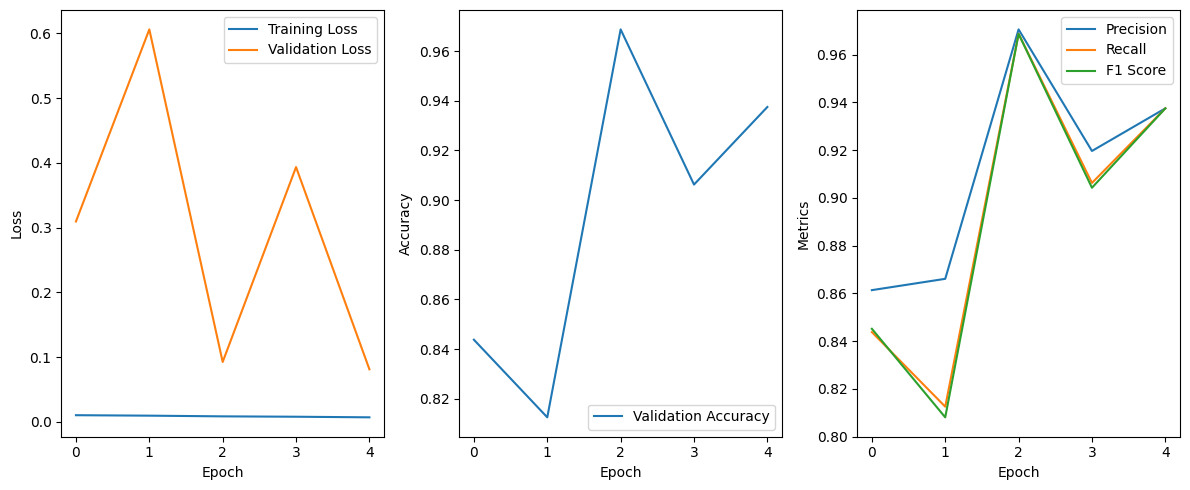

In [ ]:
import matplotlib.pyplot as plt


# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision, recall, and F1 Score
plt.subplot(1, 3, 3)
plt.plot(precision_history, label='Precision')
plt.plot(recall_history, label='Recall')
plt.plot(f1_score_history, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()


## TESTING SAMPLE IMAGES

```
# random 10 samples of images with 5 of both class.
```



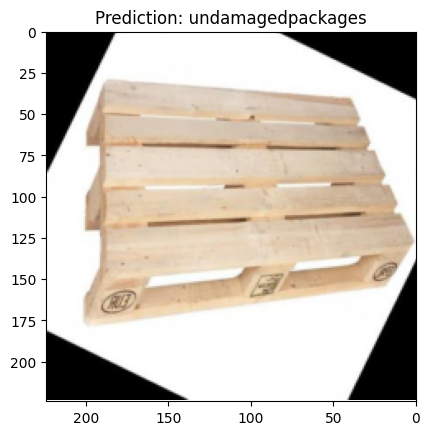

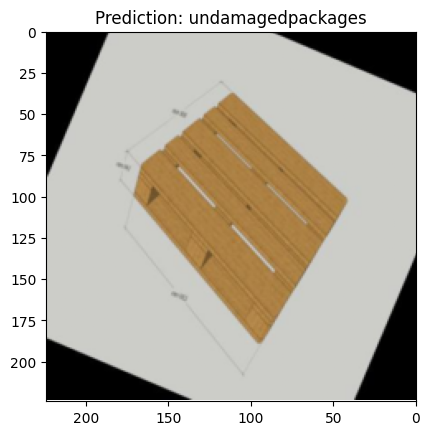

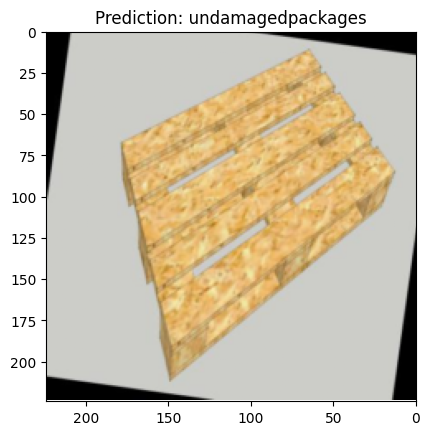

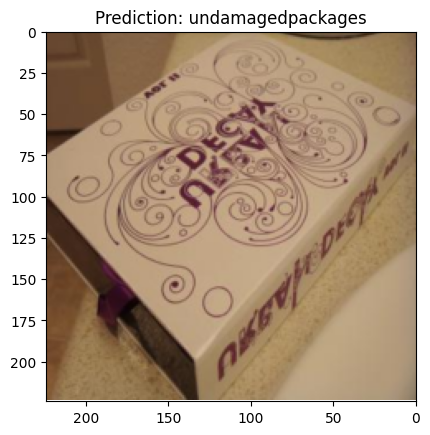

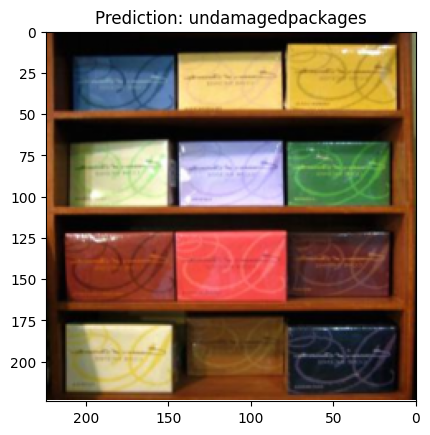

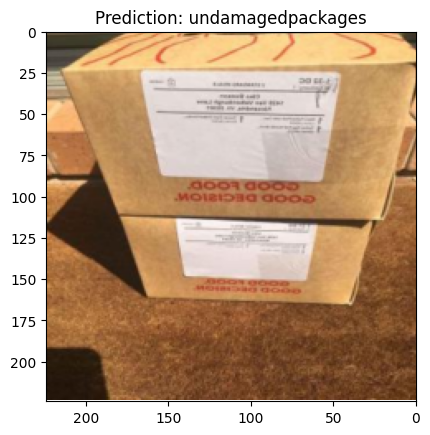

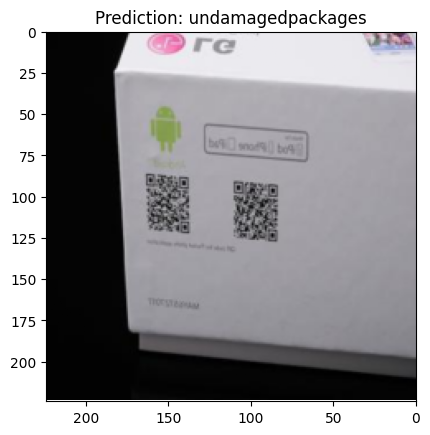

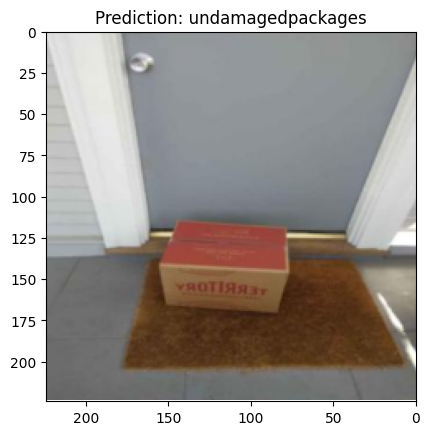

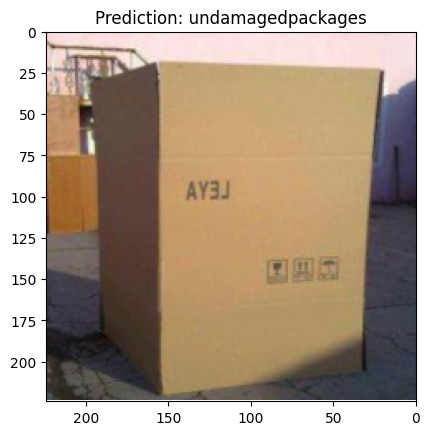

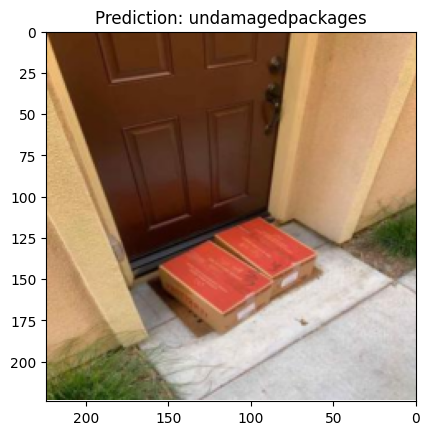

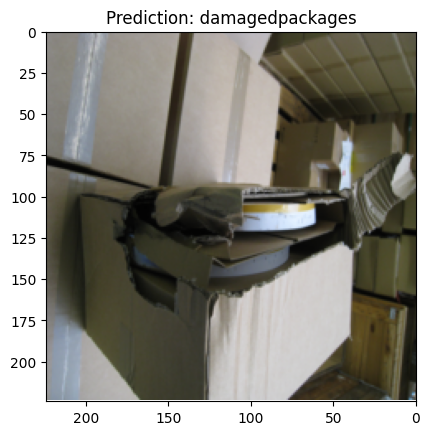

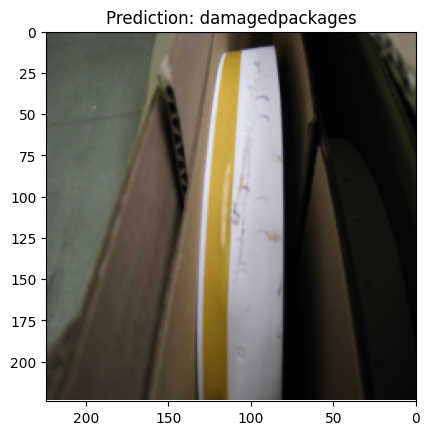

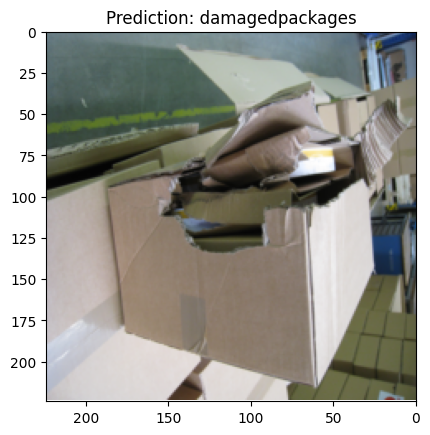

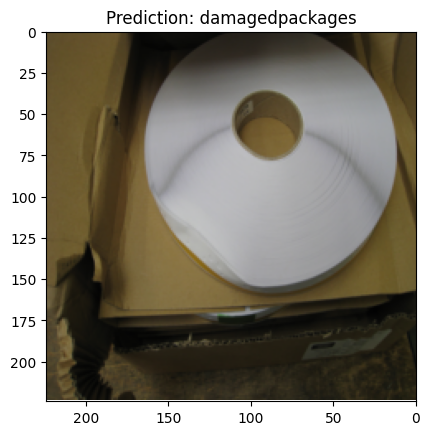

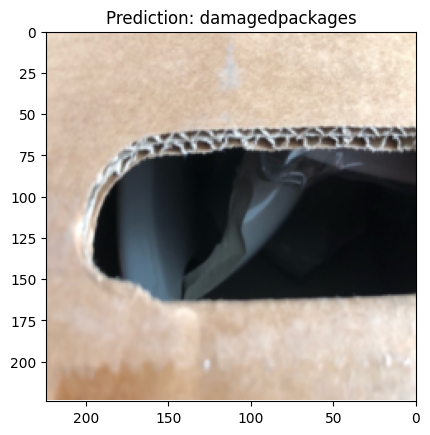

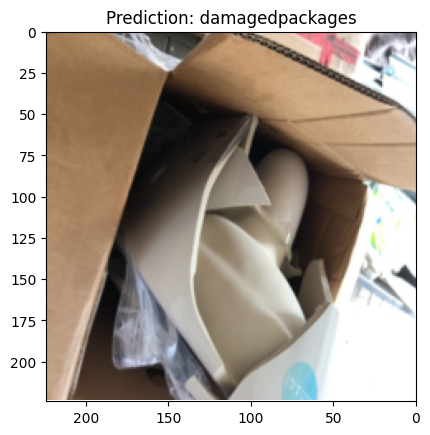

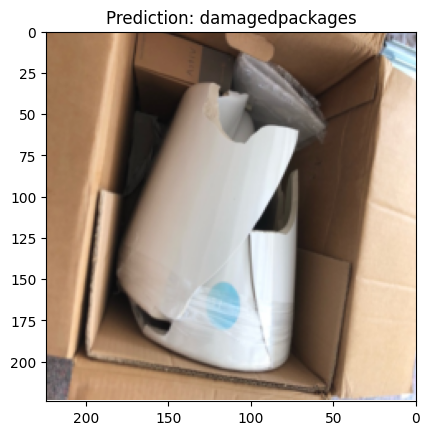

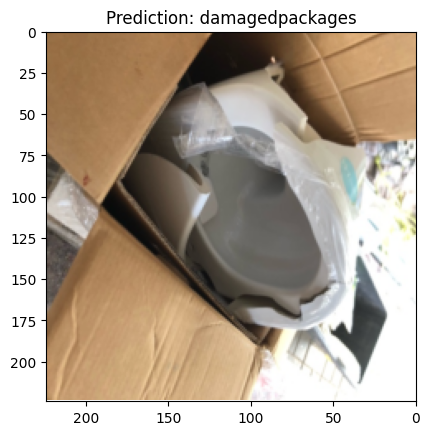

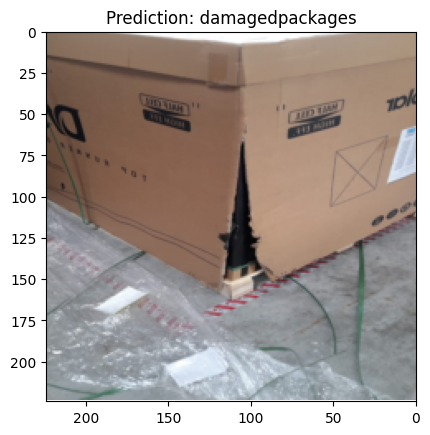

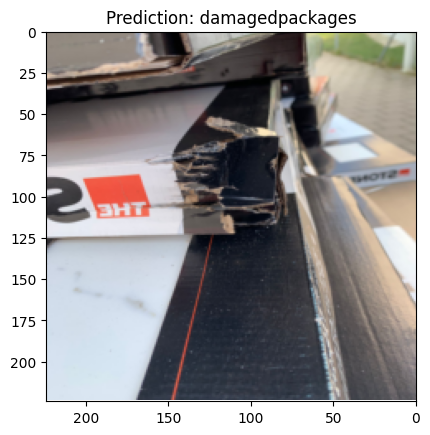

In [ ]:
import os
from PIL import Image

model = torch.load('/content/gdrive/MyDrive/testing_and_saved_model/Vision_Transformer.pt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the images from the test folder
images = []
for filename in os.listdir('/content/gdrive/MyDrive/testing_and_saved_model/new_testing'):
    if filename.endswith('.DS_Store'):
        continue

    image_path = os.path.join('/content/gdrive/MyDrive/testing_and_saved_model/new_testing', filename)
    image = Image.open(image_path).convert('RGB')
    images.append(image)

# Iterate over the images and make predictions
for image in images:
    # Resize the image to 224 x 224
    image = transforms.Resize((224, 224))(image)

    # Convert the image to a tensor
    image = transforms.ToTensor()(image)

    # Send the image to the appropriate device
    image = image.unsqueeze(0)
    image = image.to(device)

    # Make the prediction
    prediction, _ = model(image, labels=None)

    # Move the prediction tensor to the CPU
    prediction = prediction.cpu()

    # Detach the prediction tensor so it doesn't require gradient tracking
    prediction = prediction.detach().numpy()

    # Get the predicted class index
    predicted_class = np.argmax(prediction)

    # Get the predicted class label
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]

    # Display the prediction
    image_numpy = image.cpu().numpy()
    image_numpy = image_numpy.squeeze(0)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    plt.imshow(image_numpy)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Prediction: {value_predicted}')
    plt.show()


In [ ]:
from torchvision.transforms import transforms as T
from torchvision import transforms
import os
from PIL import Image

train_dataset = MyDataset('/content/gdrive/MyDrive/Parcel Damage Classification/train',
                       T.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                       ]))
validation_dataset = MyDataset('/content/gdrive/MyDrive/Parcel Damage Classification/valid',
                         T.Compose([
                             transforms.Resize((224, 224)),
                             transforms.ToTensor(),
                         ]))


## Evaluate on a Validation Images

Finally, let's evaluate the model on a test image:

torch.Size([1, 3, 540, 540])


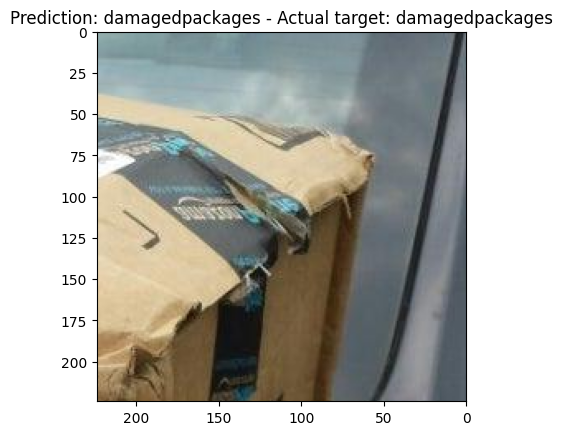

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4)
# Disable grad
with torch.no_grad():

  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)

  # Generate prediction
  prediction, loss = model(inputs, target)

  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]


  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

## Save the Entire Model

We can save the entire model as follows:

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/testing_and_saved_model/Vision_Transformer.pt')

## Export Trained Model

Now that you have trained your custom vision transformer, you can export the trained model you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/model.pt /content/gdrive/My\ Drive

Mounted at /content/gdrive


## Use your Exported Model

In [ ]:
MODEL_PATH = '/content/model.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea